In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

- `yfinance` docs: https://github.com/ranaroussi/yfinance
- What is `SPY`? See here: https://finance.yahoo.com/quote/SPY/

### Get Data

In [2]:
df_spy = yf.download('SPY')

[*********************100%%**********************]  1 of 1 completed


In [3]:
df_spy.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-27,506.700012,507.160004,504.750000,506.929993,506.929993,48854500
2024-02-28,505.329987,506.859985,504.959991,506.260010,506.260010,56506600
2024-02-29,508.070007,509.739990,505.350006,508.079987,508.079987,83924800
2024-03-01,508.980011,513.289978,508.559998,512.849976,512.849976,76805900
2024-03-04,512.030029,512.878784,512.000000,512.710022,512.710022,10094327


In [4]:
df_spy.to_csv('SPY.csv', index=True)

In [5]:
df_spy.reset_index(inplace=True)
df_spy['trend'] = df_spy.index + 1

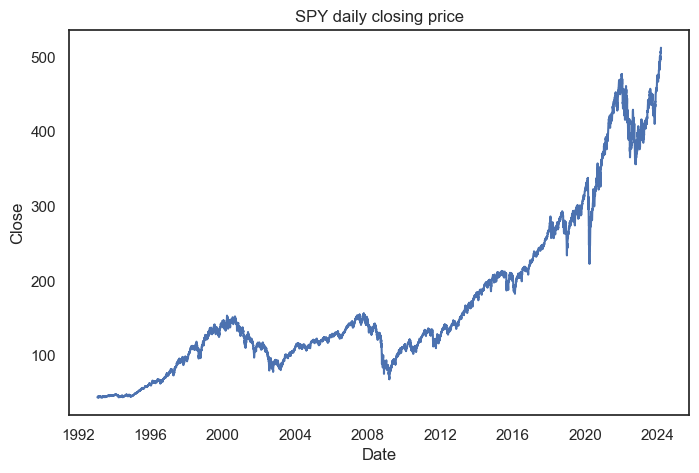

In [6]:
sns.set(style="white")
close_plot, ax1 = plt.subplots(figsize=(8,5))
close_fig = sns.lineplot(
    data = df_spy,
    x = 'Date', y = 'Close')
close_fig.set(title='SPY daily closing price')
close_plot.show()

In [11]:
# create the y variable
df_spy['next_day_close'] = df_spy['Close'].shift(-1)
# drop the last day as there's no actual price
df_spy = df_spy.iloc[:-1]

df_spy['Date_ts'] = pd.to_datetime(df_spy['Date'])
df_spy['year'], df_spy['month'], df_spy['day_of_week'], df_spy['week_of_year'] = df_spy['Date_ts'].apply(lambda x: x.year), df_spy['Date_ts'].apply(lambda x: x.month), df_spy['Date_ts'].apply(lambda x: x.dayofweek), df_spy['Date_ts'].apply(lambda x: x.weekofyear)

df_spy['closing_price_diff'] = (df_spy['Close'] / df_spy['Close'].shift(1)) - 1
df_spy['closing_price_diff'] = df_spy['closing_price_diff'].fillna(0)

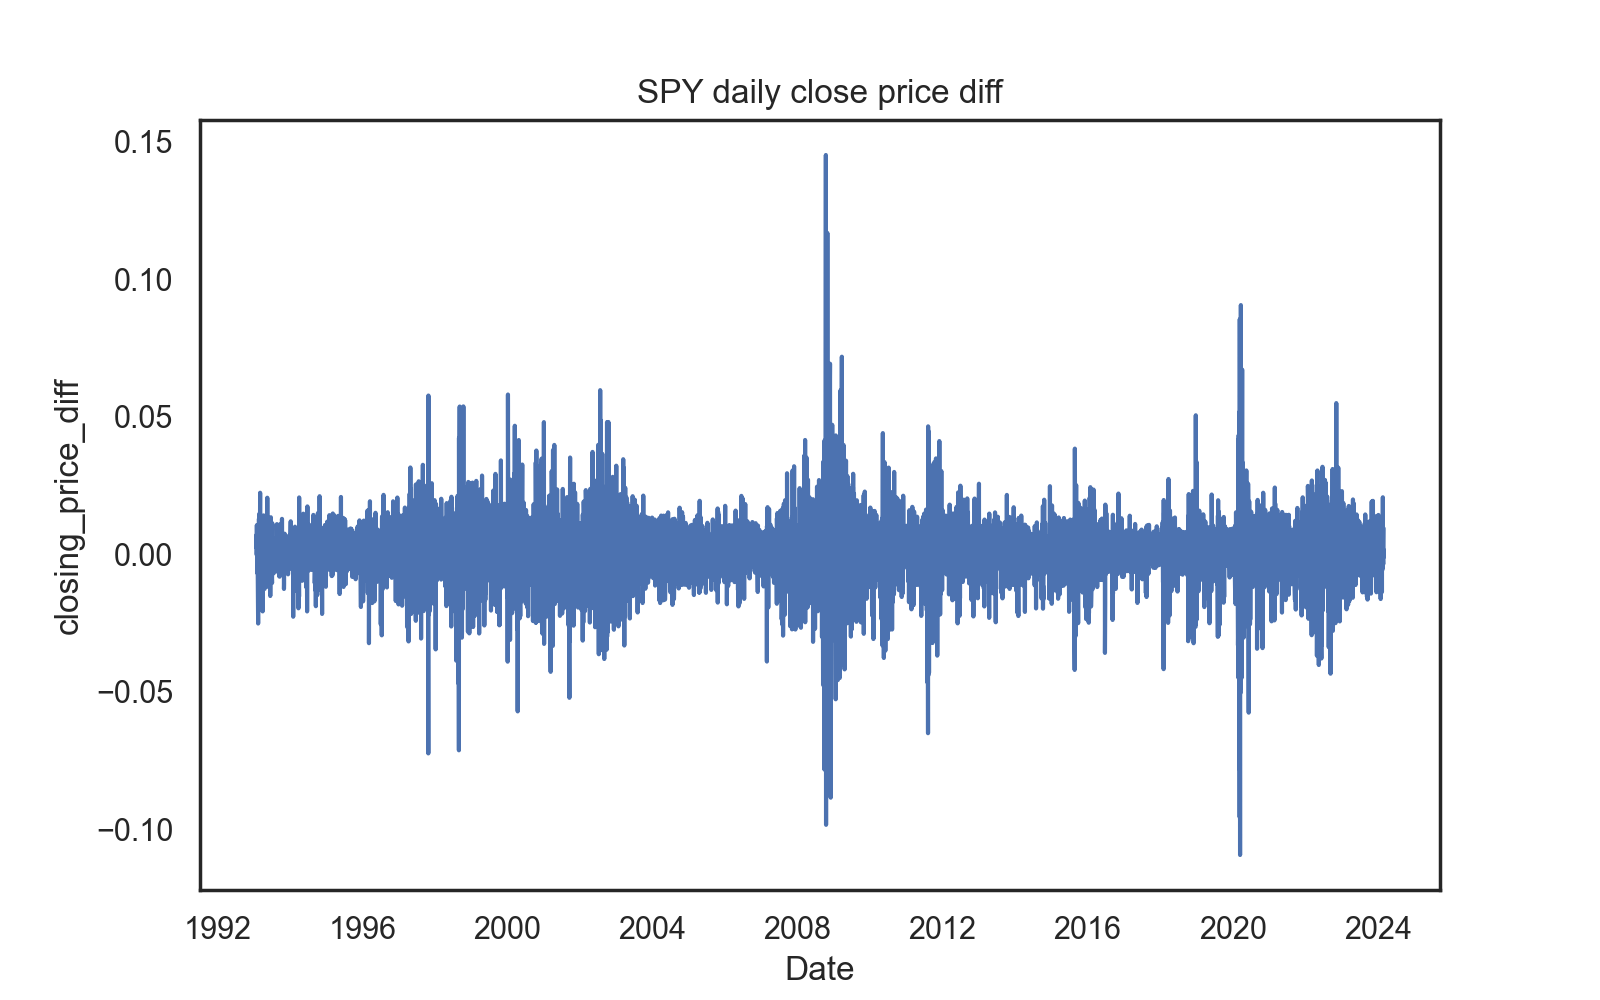

In [144]:
sns.set(style="white")
close_diff_plot, ax3 = plt.subplots(figsize=(8,5))
closs_diff_fig = sns.lineplot(
    data = df_spy,
    x = 'Date', y = 'closing_price_diff')
closs_diff_fig.set(title='SPY daily close price diff')
close_diff_plot.show()

<Axes: xlabel='day_of_week', ylabel='month'>

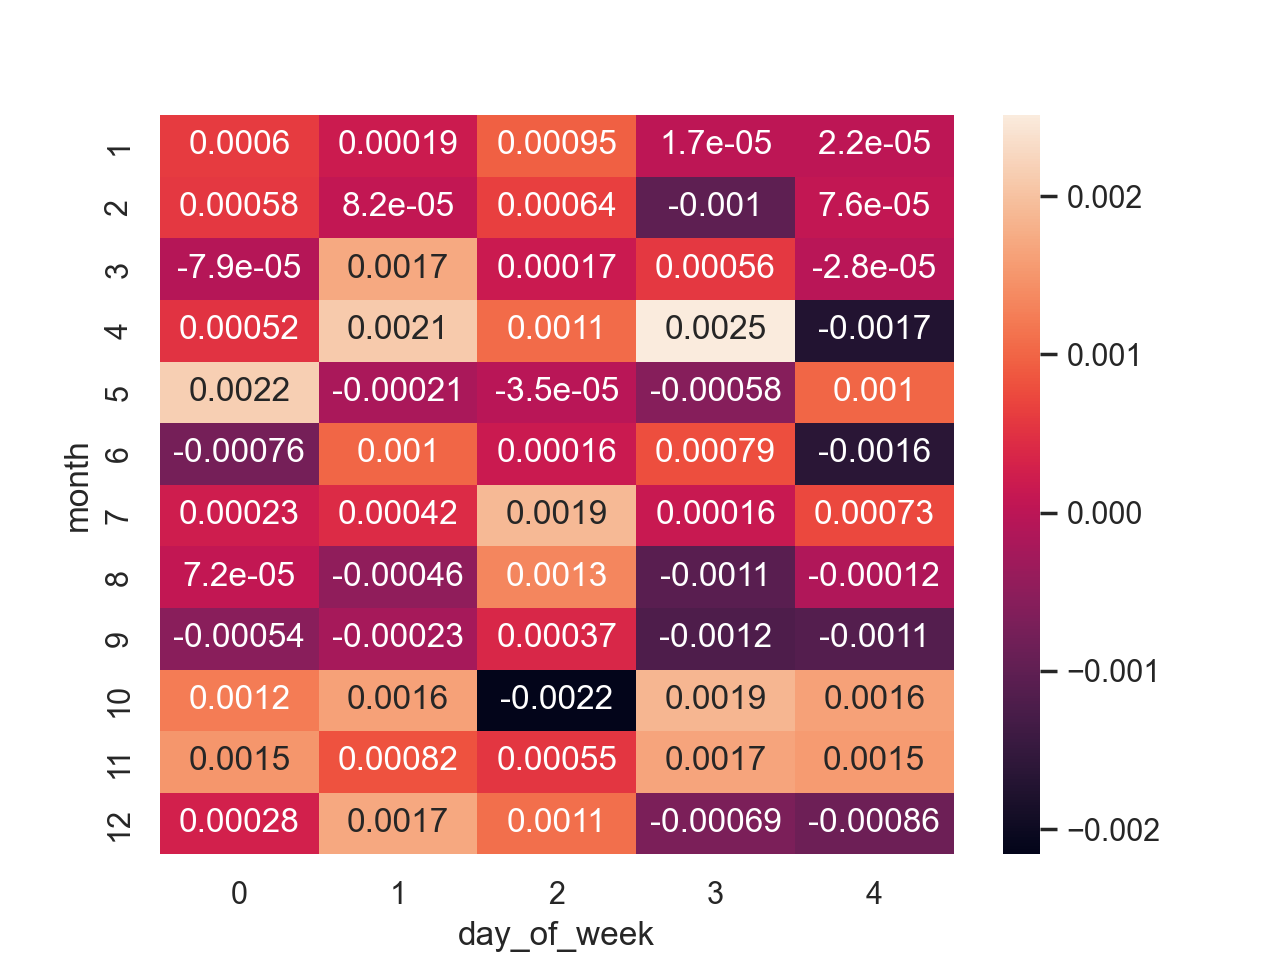

In [147]:
sns.set(style="white")
close_diff_heatmap_data = df_spy.pivot_table(index='month', columns='day_of_week', values='closing_price_diff', aggfunc='mean')
close_diff_heatmap = sns.heatmap(close_diff_heatmap_data, annot = True, 
    # which colormap do you prefer?
    # cmap = 'turbo',
    # cmap = 'coolwarm'
)
close_diff_heatmap

### Modelling 
# Prediction

In [ ]:
# Your codes for features & modelling goes here

### Save forecast

In [ ]:
firstname = '' # fill in your first name
lastname = '' # fill in your last name
filename = f'{firstname}_{lastname}.csv'

df.forecast.columns = ['date', f'{firstname}_{lastname}']

df_forecast.to_csv(filename, index = 0)

### What to turn in?

- Your Jupyter notebook which builds the model and makes the forecast. (Just for curiosity.)
- A csv file with your forecasts with the following columns   
      - date: dates   
      - firstname_lastname: forecast SPY closing prices